In [1]:
import os
import pandas as pd
import numpy as np
import keras
from keras import layers
import tensorflow as tf
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

2024-05-07 13:45:18.111110: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 13:45:29.146817: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 13:45:51.022319: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 13:46:11.804273: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dataset_directory = "trafficsigns_dataset"

#Gets class names by listing directories
class_names = sorted(os.listdir(dataset_directory)) 
print("Class names:", class_names)

#prints class name and corresponding index
print("Class names and their corresponding indices:")
for index, name in enumerate(class_names):
    print(f"Class {index}: {name}")

FileNotFoundError: [Errno 2] No such file or directory: 'trafficsigns_dataset'

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Setting 20% of the data for validation
)


Found 3681 files belonging to 5 classes.
Using 2945 files for training.
Using 736 files for validation.


In [ ]:
# Directory where your images are stored
directory = 'trafficsigns_dataset/'

# Training generator
train_generator = datagen.flow_from_directory(
    directory,
    target_size=(28, 28),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training'
)

# Validation generator
validation_generator = datagen.flow_from_directory(
    directory,
    target_size=(28, 28),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
)

2024-04-27 14:02:26.982296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


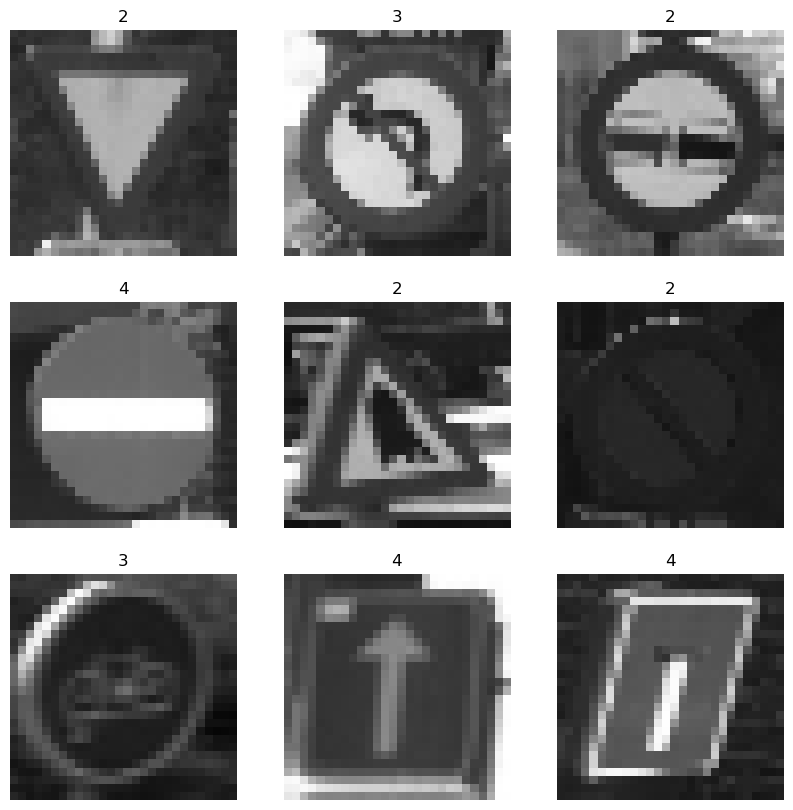

In [ ]:
import scipy
from scipy.ndimage import gaussian_filter, binary_dilation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [4]:
#confirming shape of images
batch_size = 32
train_dataset = train_generator[0]

# Print the shapes of the images and labels
print("Images shape:", train_dataset[0].shape)
print("Labels shape:", train_dataset[1].shape)

(32, 28, 28, 3)


2024-04-27 14:02:27.155623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
num_classes = 5

model = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (5, 5), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax') 
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

In [ ]:
epochs = 15
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
history = model.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator,
)

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')  
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  
plt.title('Training and Validation Accuracy') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy') 
plt.legend()
plt.grid(True)
plt.show()

## Type classification model

In [ ]:
# Do not run unless using google colab
!unzip trafficsigns_dataset_withtype.zip
%ls

In [ ]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd
import zipfile
with zipfile.ZipFile('./types.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

sign_type_class_names = ['rightofway','stop','bicycle','limitedtraffic','noentry','noparking','roundabout','speed','trafficdirective','traveldirection','continue',
                         'crossing','laneend','parking','giveway','warning']

import glob
image_list = []
for filepath in glob.glob('./types/*/*.png', recursive=True):
    filename = filepath.split('/')[-1]
    sign_type = filepath.split('/')[-2]
    image_list.append((filepath, sign_type))

data = pd.DataFrame(data=image_list, columns=['image_path', 'sign_type'])

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="image_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="image_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
reg_lambda = 0.001
OUTPUT_CLASSES = 16

model_leNet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),


    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [ ]:
sgd = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_leNet.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history = model_leNet.fit_generator(train_generator,
                                    validation_data = validation_generator,
                                    epochs=100, verbose=0)

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], 'r--')
plt.plot(history.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

## Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                  rotation_range=15, width_shift_range=0.2,
                                  height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="image_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="image_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
model_leNet_aug = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),


    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

model_leNet_aug .compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history = model_leNet_aug .fit_generator(train_generator,
                                    validation_data = validation_generator,
                                    epochs=150, verbose=0)

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], 'r--')
plt.plot(history.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_data,
    directory = './',
    x_col = 'image_path',
    y_col = 'sign_type',
    target_size = (28, 28),
    batch_size = batch_size,
    class_mode = 'categorical'
)

In [ ]:
model_leNet_aug.evaluate(test_generator)

# Independent Evaluation

In [ ]:
# Load independent images, store in dataframe, stick in model
